<img src="https://www.dascena.com/hubfs/Bravo%20Website/Images/Dascena_Logo.svg" width="240" height="240" align="center"/>

# Dascena Data Science Sample

This exercise will give you a small sample of one type of problem we specialize in at Dascena, prediction of clinically significant events using machine learning. This is also a way for you to show us your prefered style of: 

1. writing code in a way that is easy to understand and self-explainatory
2. documentation: ie comments, descriptions of inputs and outputs within the function, etc
3. data science: data visualizations, statistics, machine learning theory 
4. writing efficient code: modularity, parallelization
5. communicating technical information and concepts 
6. resourcefulnes and self teaching 

Modify this notebook as if you were going to use it to teach an undergraduate class on machine learning. Part of our follow up interview is to have you teach us how to reproduce and understand your work in this notebook.

Feel free to import other python packages, here are some basic ones to get started

In [4]:
from google.colab import drive
#drive.mount('/content/drive')

In [5]:
import os, sys, time, re, random, math, json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


## Load the Sample Dataset

Along with this jupyter notebook you should have received one other file called `berlin_ards.json` (Please unzip if you receive a zip file). It is a json file containing the data that we will be working with for this project. Load it with the cell below

In [6]:
with open('berlin_ards.json') as json_file:
    berlin_ards = json.load(json_file)

## Introduction to the Sample Dataset

This sample dataset is a subset taken from a freely accessible critical care database. `berlin_ards` above is a dictionary of patient encounters. An encounter is one hospitalization. One patient can have multiple admissions to the hospital. Each admission would have a unique encounter_ID. In this dataset the times have been modified but the time intervals are real. Run the cells below to get acquainted.

In [7]:
keys = list(berlin_ards.keys())
num_encs = len(keys)
print("There are {} patient encounters in this dataset".format(num_encs))

There are 8709 patient encounters in this dataset


In [8]:
print("{} is an example of an encounter ID".format(keys[0]))

200021 is an example of an encounter ID


plug the encounter ID into the dictionary to see information about this patient's encounter

here is some basic information about this hospitalization and all the keys to the other types of data for this encounter

In [9]:
enc = berlin_ards[keys[0]]
print('')
print(enc['Info'])
enc.keys()


{'age': 60.0, 'gender': 'M', 'weight': 82.6, 'subject_id': '61691', 'is_in_hospital_death': False, 'is_Berlin_ARDS': False, 'first_measurement_time': '2114-12-26T20:40:00', 'is_Berlin_time': '2114-12-26T21:23:00', 'last_measurement_time': '2114-12-27T22:00:00'}


dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])

Most of this you will have to figure out for yourself, but lets go over some special data components

First, we have given you a feature matrix of timeseries features where each row is a different vital sign or lab measurement and each column is a different timestep starting with column 0 = time zero.  

As an example, here are the first 24 hours of oxygen saturation (SpO2) measurements. The first SpO2 measurement was made 60 minutes into the stay, which is why the first 2 columns are not a number

In [10]:
print(enc['feature_matrix_row_names'])
period = enc['feature_sampling_interval_minutes']
print('number of features', len(enc['feature_matrix_row_names']))
print('minutes between timesteps', period)
feature_index = 5
print(enc['feature_matrix_row_names'][feature_index])
feature_matrix = np.array(enc['feature_matrix'])
print(feature_matrix[feature_index,:int(24*60/period)])
print(feature_matrix.shape)

['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
number of features 9
minutes between timesteps 30
SpO2
[nan nan 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 98. 98. 96. 96. 94.
 94. 97. 97. 96. 96. 96. 96. 94. 94. 94. 94. 94.]
(9, 51)


### Sanity Check

The length of stay should be within one period of the amount of time represented by the feature matrix

In [11]:
start_time = datetime.strptime(enc['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
stop_time = datetime.strptime(enc['Info']['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')

lenofstay_mins = (stop_time - start_time).total_seconds()/60
print(int(lenofstay_mins/60), 'hours', feature_matrix.shape[1]*period/60, 'hours')

25 hours 25.5 hours


# Exploring the Data

For the 3 features: 

    a. Systolic Blood Pressure (SysABP)

    b. Temperature (Temp) 

    c. White Blood Cell Count (WBC)
    
## TODOs:

1. Generate figures to describe the distribution of these features: ie their variability and central tendency. Make the figures as easy to read and self-explainatory as possible as if you were going to publish them. 

2. Look up each these 3 features. Have you plotted a clinically plausible, ie physiologically distributed, spread of measurements that you would expect for each feature ? 

4. What are the units of measurment each feature likely uses ? 

In [12]:
import pandas as pd
import seaborn as sns


#Storing the json contents into a dataframe
df=pd.read_json ('berlin_ards.json')
df = df.transpose()
df = pd.concat([df.drop(['Info'], axis=1), df['Info'].apply(pd.Series)], axis=1)

names = ['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']


df['SysABP'] = [i[0] for i in df['feature_matrix']]
df['DiasABP'] = [i[1] for i in df['feature_matrix']]
df['HR'] = [i[2] for i in df['feature_matrix']]
df['Temp'] = [i[3] for i in df['feature_matrix']]
df['RespRate'] = [i[4] for i in df['feature_matrix']]
df['SpO2'] = [i[5] for i in df['feature_matrix']]
df['Creatinine'] = [i[6] for i in df['feature_matrix']]
df['WBC'] = [i[7] for i in df['feature_matrix']]
df['Platelets'] = [i[8] for i in df['feature_matrix']]

df = df.drop(['feature_matrix'], axis=1)
df = df.drop(['feature_matrix_row_names'], axis=1)

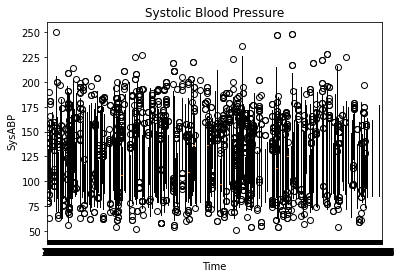

In [22]:
#### WRITE CODE HERE #####

import warnings; warnings.simplefilter('ignore')
def boolean_indexing(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out



#Generating a matrix
sysabp = [np.array(i, dtype=np.float) for i in df['SysABP']]
sysabp = boolean_indexing(sysabp)

#Plotting SysABP of patients with respect to the time
sysabp = sysabp.transpose()
plt.boxplot(sysabp)
plt.ylabel("SysABP")
plt.xlabel("Time")
plt.title("Systolic Blood Pressure")
plt.show()

#### WRITE CODE HERE #####

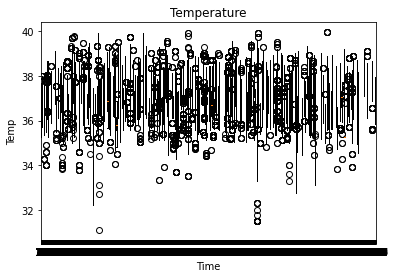

In [23]:
#### WRITE CODE HERE #####
#Generating a matrix
temp = [np.array(i, dtype=np.float) for i in df['Temp']]
temp = boolean_indexing(temp)

#Plotting Temperature of patients with respect to the time.
temp = temp.transpose()
plt.boxplot(temp)
plt.ylabel("Temp")
plt.xlabel("Time")
plt.title("Temperature")
plt.show()

#### WRITE CODE HERE #####

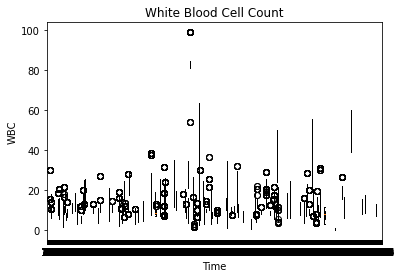

In [24]:
#### WRITE CODE HERE #####
#Generating a matrix
wbc = [np.array(i, dtype=np.float) for i in df['WBC']]
wbc = boolean_indexing(wbc)

#Plotting White Blood Cell Count of patients with respect to the time
wbc = wbc.transpose()
plt.boxplot(wbc)
plt.ylabel("WBC")
plt.xlabel("Time")
plt.title("White Blood Cell Count")
plt.show()

#### WRITE CODE HERE #####

# Machine Learning

ARDS or [Acute respiratory distress syndrome](https://www.uptodate.com/contents/acute-respiratory-distress-syndrome-clinical-features-diagnosis-and-complications-in-adults) is a difficult disease both to define and also to predict. The definition of ARDS we will be using is the Berlin Criteria (Lung imaging shows Bilateral Infiltrates and PaO2/FiO2 is < 300). We are going to have you design and train an algorithm to predict the onset of ARDS before it occurs as best you can using the limited data in this sample dataset. The target labels are provided for you for each patient encounter, see below:

In [16]:
encounter_index = 1
print('Did this patient develope ARDS according to the Berlin Criteria?',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_ARDS'])
print('Time Berlin Criteria was evaluated',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_time'])

Did this patient develope ARDS according to the Berlin Criteria? False
Time Berlin Criteria was evaluated 2127-03-03T17:27:00


### Guidelines

a. You can choose which machine learning algorithm and python packages to use 

b. You can choose which features to use. 

c. Only use features as inputs to the algorithm that are available at or before the time you plan to make the prediction. If ARDS occurs at 48 hours into the hospitalization and your machine learning algorithm makes a prediction at 24 hours into the hospitalization, make sure you are not using information from the dataset that becomes available only after 24 hours. 


## TODOs:

1. Set aside a portion of the encounters to use as the hold out test set.

2. Train and validate the algorithm on the remaining dataset.

2. Plot the area under the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) aka AUC on the hold out test set. 

3. Generate a figure to help us understand how the algorithm makes it's decisions. ie address model interpretability. 

In [17]:
def calculate_mean(values):
  res = [[i for i in rows if i] for rows in values]
  mean_values=[]
  for i in res:
    try:
      mean_values.append(np.mean(i))
    except IndexError:
      mean_values.append(None)
  return mean_values

#creating a new dataset with patients diagnosed with ARDS
df_new = df.loc[df['is_Berlin_ARDS'] == True]
#removing those records from original dataset
df1 = df[df.is_Berlin_ARDS == False]

print(df_new)
start_time = [datetime.strptime(i, '%Y-%m-%dT%H:%M:%S') for i in df_new['first_measurement_time']]
eval_time = [datetime.strptime(i, '%Y-%m-%dT%H:%M:%S') for i in df_new['is_Berlin_time']]

#Considering the values only till the patient is diagnosed with ARDS
duration = [int(((i - j).total_seconds()/60)/30) for i, j in zip(eval_time,start_time)]

print(df_new.columns)
sysABP, diasabp, hr, Temp, resprate, sp, creatinine, WBC, platelets = ([] for i in range(9))
for i in range(len(df_new)):
    sysABP.append(list(df_new['SysABP'])[i][:duration[i]])
    diasabp.append(list(df_new['DiasABP'])[i][:duration[i]])
    hr.append(list(df_new['HR'])[i][:duration[i]])
    Temp.append(list(df_new['Temp'])[i][:duration[i]])
    resprate.append(list(df_new['RespRate'])[i][:duration[i]])
    sp.append(list(df_new['SpO2'])[i][:duration[i]])
    creatinine.append(list(df_new['Creatinine'])[i][:duration[i]])
    WBC.append(list(df_new['WBC'])[i][:duration[i]])
    platelets.append(list(df_new['Platelets'])[i][:duration[i]])

import warnings; warnings.simplefilter('ignore')


df_new['SysABP'] =  calculate_mean(sysABP)
df_new['DiasABP'] = calculate_mean(diasabp)
df_new['HR'] = calculate_mean(hr)
df_new['Temp'] = calculate_mean(Temp)
df_new['RespRate'] =  calculate_mean(resprate)
df_new['SpO2'] =  calculate_mean(sp)
df_new['Creatinine'] = calculate_mean(creatinine)
df_new['WBC'] = calculate_mean(WBC)
df_new['Platelets'] = calculate_mean(platelets)

df1['SysABP'] =  calculate_mean(list(df1['SysABP']))
df1['DiasABP'] = calculate_mean(list(df1['DiasABP']))
df1['HR'] = calculate_mean(list(df1['HR']))
df1['Temp'] = calculate_mean(list(df1['Temp']))
df1['RespRate'] =  calculate_mean(list(df1['RespRate']))
df1['SpO2'] =  calculate_mean(list(df1['SpO2']))
df1['Creatinine'] = calculate_mean(list(df1['Creatinine']))
df1['WBC'] = calculate_mean(list(df1['WBC']))
df1['Platelets'] = calculate_mean(list(df1['Platelets']))

df1 = pd.concat([df1,df_new])
print(df1)

       feature_sampling_interval_minutes  ...                                          Platelets
200143                                30  ...  [None, None, None, None, None, 358.0, 358.0, 3...
200525                                30  ...  [None, None, None, None, 202.0, 202.0, 202.0, ...
200636                                30  ...  [None, 235.0, 235.0, 235.0, 235.0, 235.0, 235....
200647                                30  ...  [None, None, None, None, None, None, None, Non...
200952                                30  ...  [None, None, None, None, None, None, None, Non...
...                                  ...  ...                                                ...
227590                                30  ...  [None, None, None, None, None, None, None, Non...
239460                                30  ...  [None, None, None, None, None, None, None, Non...
272836                                30  ...  [None, None, None, 456.0, 456.0, 456.0, 456.0,...
279670                        

In [18]:
#### WRITE CODE HERE #####

from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
dummy_df= df1[['gender','is_in_hospital_death','is_Berlin_ARDS']]
dummy_df = dummy_df.apply(le.fit_transform)

df1 = df1.drop(['gender','is_in_hospital_death','is_Berlin_ARDS'], axis=1)
df1 = pd.concat([df1, dummy_df], axis=1, sort=False)

y= df1['is_Berlin_ARDS']
X = df1.drop(['is_in_hospital_death','feature_sampling_interval_minutes','subject_id','is_Berlin_ARDS','first_measurement_time','is_Berlin_time','last_measurement_time'], axis=1)


print(X.columns)

X = X.fillna(method='ffill')
print(X)

#### WRITE CODE HERE #####

Index(['age', 'weight', 'SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2',
       'Creatinine', 'WBC', 'Platelets', 'gender'],
      dtype='object')
         age  weight      SysABP  ...        WBC   Platelets  gender
200021  60.0    82.6  112.280000  ...   6.100000  156.000000       1
200024  80.0    82.6  107.000000  ...  12.400000  127.000000       0
200028  64.0    84.4  117.382353  ...  10.518519   71.555556       1
200053  40.0   121.8  152.147887  ...   7.015194  173.936396       1
200063  37.0   146.7  116.754579  ...   7.405435  171.612319       1
...      ...     ...         ...  ...        ...         ...     ...
227590  37.0   109.0  122.833333  ...  10.687097  233.000000       1
239460  42.0   108.0  130.181818  ...  27.500000  321.000000       1
272836  32.0    88.5  116.125000  ...   9.800000  456.000000       1
279670  65.0    74.3  125.777778  ...   9.800000  456.000000       1
276230  51.0    74.3  125.777778  ...   9.800000  326.000000       1

[8709 rows x 12 co

In [19]:
#### WRITE CODE HERE #####

#Selecting relevant features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

'''
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)
np.set_printoptions(precision=4)
print(fit.scores_)
features = fit.transform(X)
print(features)
'''

from sklearn.feature_selection import RFE

model = RandomForestClassifier()
rfe = RFE(model, 4)
fit = rfe.fit(X, y)
#the least ranked columns were dropped from dataframe X (the columns were dropped through the previous block code)
print("Feature Ranking: %s" % (fit.ranking_))



#### WRITE CODE HERE #####

Feature Ranking: [8 7 1 3 1 2 1 1 6 4 5 9]


In [20]:
#### WRITE CODE HERE #####
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix


# Split our data
train, test, train_labels, test_labels = train_test_split(X,y, test_size=0.25,random_state=50, stratify=y)


#Using Random Forest Classifier
model = RandomForestClassifier()
model = model.fit(train, train_labels)
preds = model.predict(test)
print("Accuracy using Random Forest is " ,accuracy_score(test_labels, preds))
print(classification_report(test_labels, preds))

#### WRITE CODE HERE #####


Accuracy using Random Forest is  0.9522497704315886
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2068
           1       0.80      0.07      0.13       110

    accuracy                           0.95      2178
   macro avg       0.88      0.54      0.55      2178
weighted avg       0.95      0.95      0.93      2178



AUC: 0.82


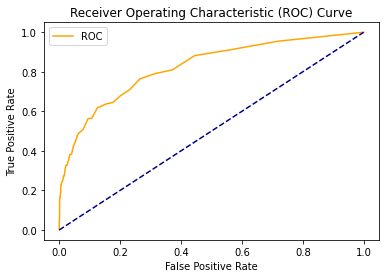

In [21]:
#### WRITE CODE HERE #####
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs = model.predict_proba(test)
probs = probs[:, 1]

auc = roc_auc_score(test_labels, probs)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(test_labels, probs)
plot_roc_curve(fpr, tpr)




#### WRITE CODE HERE #####

# Open Ended Creative Section

Teach us how to do a portion of a project you worked on recently and really enjoyed. It doesn't have to be medically or supervised learning related. It just has to be in the realm of data science. 

You can use the space below to display or generate visuals, write pseudocode, do math in $Late^X$ or take us through some demo code




**PFA file showing a recent work done in collaboration with Merck & Co.**  



**Title : Applying Machine Learning Models to Identify Chronic Cough Patients using EHR Data** 





**ABSTRACT**

**Background** Chronic cough (CC) affects approximately 10% of adults. Chronic cough can be caused by asthma, gastroesophageal reflux disease and so on. Since there is no ICD code for chronic cough in the EHR, it brings challenges to identify the chronic cough cases. Therefore, it is urgent to develop computational methods to identify chronic cough cases using the EHR data and to develop treatments for chronic cough.

**Method** The goal of this paper is to conduct a systematic study on developing various machine learning models, including both deep and traditional ones, for predicting chronic cough patients. We evaluate those different approaches to real-world EHR data containing patients’ medical records from a large academic healthcare system from October 2005 and September 2015. The patient features we build the machine learning models upon including structured data - medication and diagnosis, and unstructured data - clinical notes.

**Results** Our analysis showed that the prediction performance in terms of sensitivity could be improved from around 0.86 using medication and diagnosis, to 0.95 through combining medication and diagnosis with the symptoms extracted from the clinical notes. Through the chart review validation on a subset, the best-performed model -BERT can gain a specificity of 0.73. Moreover, we also demonstrate that the attention mechanism of deep learning models can be used to extract important features that drive the prediction decisions.

**Conclusions** Deep learning models can predict the chronic cough and gain high sensitivity when both structured and unstructured data in the EHR are utilized. The specificity gained by the models can be improved if more validated patient data are involved in training.

